#  Прогнозирование заказов такси

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
data.set_index('datetime',inplace=True)

In [7]:
data.sort_index(inplace=True)

In [8]:
data = data.resample('1H').sum()

In [9]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [10]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Вывод:
- были загружены данные о заказах такси в data (26496 записей)
- в данных остуствуют пропуски
- был изменен формат данных для дат на datetime
- была выполнена группировка заказаов по часам  

## Анализ

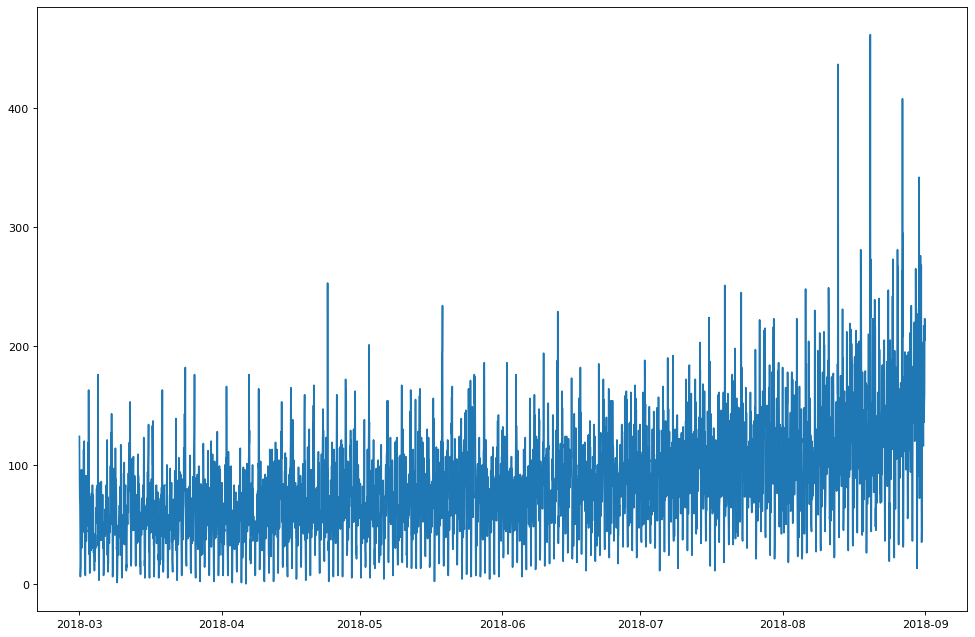

In [11]:
plt.figure(figsize=(15,10), dpi= 80)
plt.plot(data.index, data)

<AxesSubplot:xlabel='datetime'>

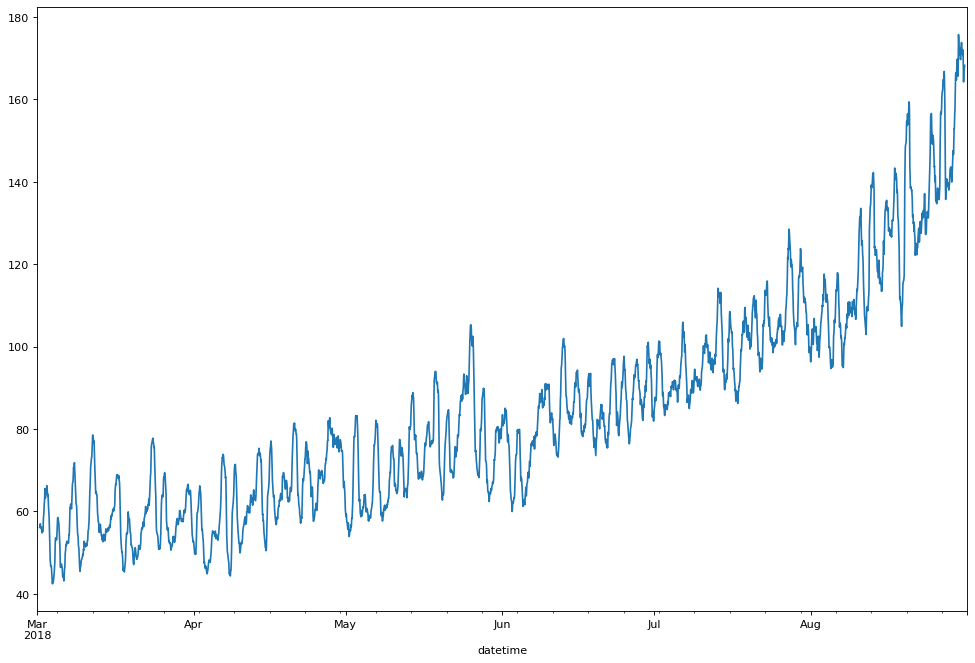

In [12]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15,10), dpi= 80)
decomposed.trend[:].plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

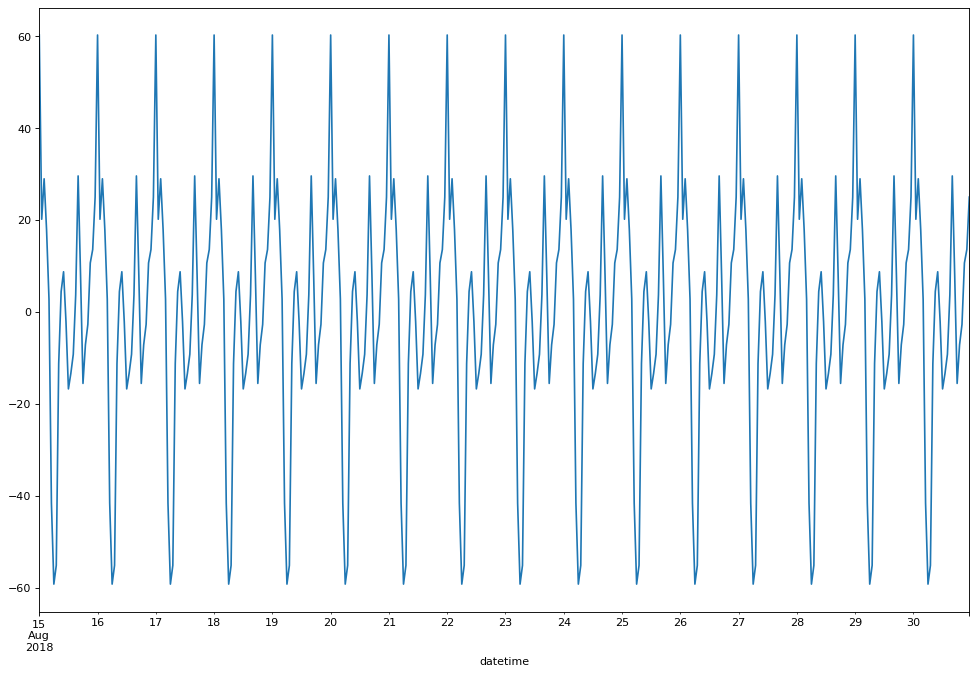

In [13]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15,10), dpi= 80)
decomposed.seasonal['2018-08-15':'2018-08-30'].plot(ax=plt.gca())

In [14]:
data['rolling_mean'] = data['num_orders'].shift().rolling(12).mean()

In [15]:
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [16]:
data['lag'] = data['num_orders'].shift(24)

In [17]:
data.head(30)

,num_orders,rolling_mean,day,dayofweek,hour,lag
datetime,,,,,,
2018-03-01 00:00:00,124,NaN,1,3,0,NaN
2018-03-01 01:00:00,85,NaN,1,3,1,NaN
2018-03-01 02:00:00,71,NaN,1,3,2,NaN
2018-03-01 03:00:00,66,NaN,1,3,3,NaN
2018-03-01 04:00:00,43,NaN,1,3,4,NaN
2018-03-01 05:00:00,6,NaN,1,3,5,NaN
2018-03-01 06:00:00,12,NaN,1,3,6,NaN
2018-03-01 07:00:00,15,NaN,1,3,7,NaN
2018-03-01 08:00:00,34,NaN,1,3,8,NaN


### Вывод:
- временной ряд не стационарный, так как со временм меняется среднее значение
- имеется тренд среднее значение по дням растет 
- имеется сезоннность, длина сезона - 24ч
- были добавлены дополнитнльные признаки: день, день недели, час и скользящее среднее 

## Обучение

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [19]:
train.dropna(inplace=True)

C:\Users\user\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [20]:
X_train = train.drop('num_orders', axis=1)

In [21]:
y_train = train['num_orders']

In [22]:
X_test = test.drop('num_orders', axis=1)

In [23]:
y_test = test['num_orders']

In [24]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((3950, 5), (3950,), (442, 5), (442,))

In [25]:
#модель лин регрессии
linreg = LinearRegression()
tscv = TimeSeriesSplit(n_splits=4)
result = cross_val_score(linreg, X_train, y_train, cv=tscv,scoring = 'neg_root_mean_squared_error')
linreg.fit(X_train,y_train)
np.mean(abs(result))

28.979767603688668

In [26]:
#модель случайного леса
params = {'n_estimators': [3, 5, 7, 10], 
          'max_depth': [3, 5, 7, 10],
          'min_samples_split': [2, 4],
          'min_samples_leaf' : [1, 3, 5]
         }
forrest = RandomForestRegressor(random_state = 123 )    
grid_forrest = GridSearchCV(forrest, param_grid=params, cv=tscv, scoring='neg_mean_squared_error')
grid_forrest.fit(X_train, y_train)
print(abs(grid_forrest.best_score_)**0.5)
best_params_forrest = grid_forrest.best_params_

26.715457008810105


### Вывод:
- были выделены обучающая и тестовая выборки, доля тестовой выборки - 10%
- была обучена модель линейной регрессии, RMSE на валидационной выборке составил 29
- была обучена модель случайного леса, RMSE  составил 26,71

## Тестирование

In [27]:
#модель лин регрессии проверка на тестовой выборке
mean_squared_error (y_test,linreg.predict(X_test),squared=False)

49.56630061995804

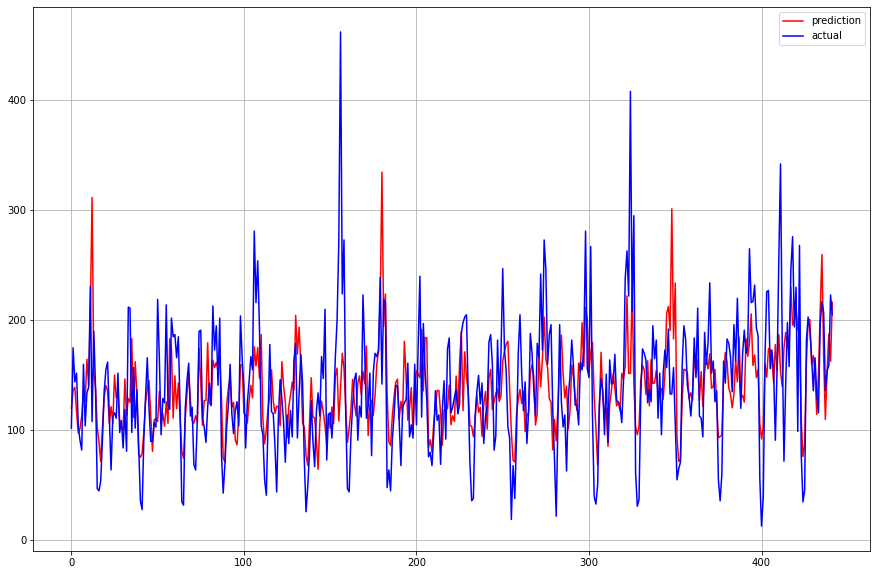

In [28]:
plt.figure(figsize=(15,10))
#plt.plot(y_test, label='actual')
plt.plot(linreg.predict(X_test),'r',label = 'prediction')
plt.plot(y_test.values,'b', label = 'actual')
plt.legend()
plt.grid(True);

In [29]:
#модель случайного леса проверка на тестовой выборке
mean_squared_error (y_test,grid_forrest.predict(X_test),squared=False)

42.6517294185103

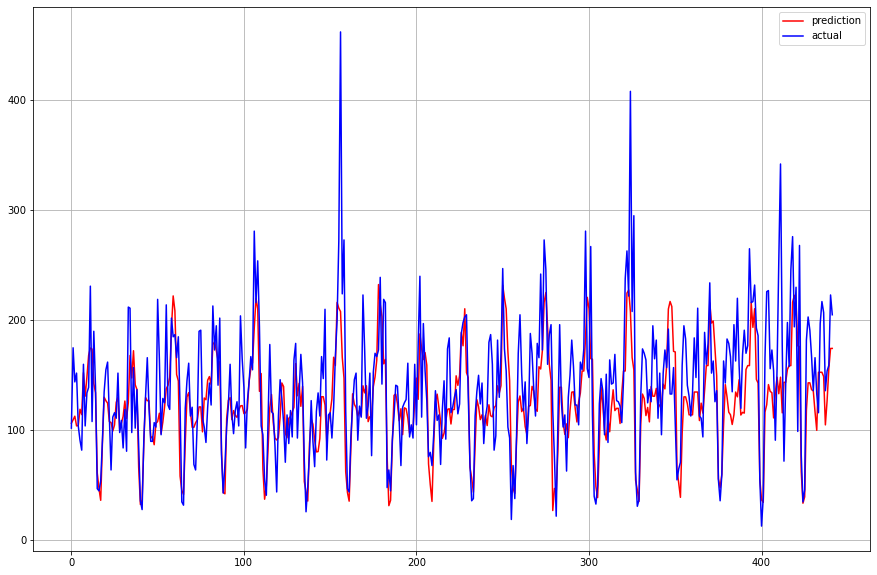

In [30]:
plt.figure(figsize=(15,10))
plt.plot(grid_forrest.predict(X_test),'r',label = 'prediction')
plt.plot(y_test.values,'b', label = 'actual')
plt.legend()
plt.grid(True);

### Вывод:
- при проверке модели лин регрессии на тестовой выборке RMSE  составил 49,57, что не удовлетворяет заданному условию
- при проверке модели случайного леса на тестовой выборке RMSE  составил 42,61, что удовлетворяет заданному условию


## Вывод:

1. На этапе подготовки данных:
- были загружены данные о заказах такси в data (26496 записей)
- в данных остуствуют пропуски
- был изменен формат данных для дат на datetime
- была выполнена группировка заказаов по часам  
- выбросы были заменены методом ‘ffill’
2. На этапе анализа данных было определено:
- временной ряд не стационарный, так как со временм меняется среднее значение
- имеется тренд среднее значение по дням растет 
- имеется сезоннность, длина сезона - 24ч
- были добавлены дополнитнльные признаки: день, день недели, час и скользящее среднее 
3. на этапе обучения моделей
- были выделены обучающая и тестовая выборки, доля тестовой выборки - 10%
- была обучена модель линейной регрессии, RMSE на валидационной выборке составил 29
- была обучена модель случайного леса, RMSE  составил 26,71
4. На этапе тестирования моделей:
- при проверке модели лин регрессии на тестовой выборке RMSE  составил 49,57, что не удовлетворяет заданному условию
- при проверке модели случайного леса на тестовой выборке RMSE  составил 42,61, что удовлетворяет заданному условию
- для построения прогноза была выбрана модель случайного леса, на ней получено более высокое значение RMSE